### Credenciais de Acesso Kaggle

In [1]:
{"username":"jcss03","key":"caf02cc87bdafff295f9eb6897072757"}

{'username': 'jcss03', 'key': 'caf02cc87bdafff295f9eb6897072757'}

### Imports

In [2]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing


import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Download Dataset

In [ ]:
# download data from kaggle
od.download("https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jcss03
Your Kaggle Key: ··········


100%|██████████| 1.99M/1.99M [00:00<00:00, 53.4MB/s]

In [ ]:
# caminho para o dataset
!ls ./twitter-entity-sentiment-analysis

twitter_training.csv  twitter_validation.csv


### Acesso ao Drive

In [ ]:
# Acesso a pasta do drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# exemplo
!ls /content/drive/MyDrive/'Trabalho de Graduação'

 apresentação  'Proposta de TG'  'Trabalho de Graduação 2022'
 Artigos        scripts


### Loading Datasets
* Train
* Test

In [ ]:
dataset_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)
dataset_validation = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)

In [ ]:
print('Exemplo do dataset')
dataset_train.sample(5)

Exemplo do dataset


,Tweet_ID,entity,sentiment,Tweet content
52138,10556,RedDeadRedemption(RDR),Neutral,Had a meeting somewhere with the interns on th...
48879,5990,HomeDepot,Positive,home depot sells safety goggles that fit comfo...
68600,3747,Cyberpunk2077,Irrelevant,@ MattJMcM1 that'd be a winner!.
49763,6142,FIFA,Negative,Gaming Trustees are terrible for collecting re...
27365,1109,AssassinsCreed,Positive,"I Can't wait for the New Assassins Creed, it a..."


#### Encodificar Targets

In [ ]:
data = dataset_train[['Tweet content','sentiment']].rename(columns={"Tweet content": "text", "sentiment": "target"})
data.target = pd.Categorical(data.target)

data['code'] = data.target.cat.codes
print('#'*100)
print(f'Targets: {data.target.unique()}')
print(f'Codes: {data.code.unique()}')
print('#'*100)
data.sample(5)

####################################################################################################
Targets: ['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Codes: [3 2 1 0]
####################################################################################################


,text,target,code
68304,I'd rather a delayed game than a broken game,Neutral,2
41429,Battlefield 4 plays so much better without Mod...,Positive,3
18557,For sale on eBay competing with several other ...,Neutral,2
23398,@CarryMinati's main channel pad was hacked and...,Negative,1
48539,"please don’t come to home alone today, bother ...",Negative,1


In [ ]:
print(f'Categorias: {data.target.cat.categories}')
# print(f'Codigos: {data.target.cat.codes}')

Categorias: Index(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype='object')


In [ ]:
TARGET_ENCODE = dict(enumerate(data.target.cat.categories))

In [ ]:
TARGET_ENCODE

{0: 'Irrelevant', 1: 'Negative', 2: 'Neutral', 3: 'Positive'}

#### Remover valores Null

In [ ]:
print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

# dropna values
data = data.dropna().reset_index(drop=True)

print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

####################################################################################################
Shape dos dados: (74682, 3)
Number null values = 686
####################################################################################################
Shape dos dados: (73996, 3)
Number null values = 0


### Processing Text
* stopwords
* punctuation
* Stemming(reducing the words to their derived stems)
* Lemmatization(reducing the derived words to their root form known as lemma)
* removing unnecessary characters
* lower case text to better generalization

In [ ]:
# recebe texto e processa
def processing_text(text,flag_punctuation=False,flag_stopwords=False,flag_stem=False,flag_lemma=False):

  ##############################################################################
  # funções

  # maketrans explained - 'https://www.w3schools.com/python/ref_string_maketrans.asp'
  def cleaning_punctuations(text):
      english_punctuations = string.punctuation
      punctuations_list = english_punctuations

      translator = str.maketrans('', '', punctuations_list)
      return text.translate(translator)
  
  # remover stopwords
  def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split(' ') if word not in stop_words])
    return text

  # removendo chars repetidos
  def cleaning_repeating_char(text):
      return re.sub(r'(.)1+', r'1', text)

  # removing stem
  def stemming(text):
    ps = PorterStemmer()
    text = " ".join([ps.stem(word) for word in text.split(' ')])
    return text

  def lemmatizer(text):
      lm = nltk.WordNetLemmatizer()
      text = " ".join([lm.lemmatize(word) for word in text.split(' ')])
      return text
  ##############################################################################

  # Processing

  # lower all string of text
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  # remover pontuações
  if flag_punctuation:
    text = cleaning_punctuations(text)

  # remover stopwords
  if flag_stopwords:
    text = remove_stopwords(text)

  # remover repetições
  text = cleaning_repeating_char(text)

  # lenma
  if flag_lemma:
    text = lemmatizer(text)

  # stem:
  if flag_stem:
    text = stemming(text)

  return text

In [ ]:
example = data.text.iloc[100]
example

'Grounded almost was pretty cool even despite the top tier unfunny writing until we became yet another annoying crafting game. I seriously can’t wait on this shitty trend to die'

In [ ]:
clean_text = processing_text(example,flag_punctuation=True,flag_stopwords=True,flag_lemma=True)
clean_text

'grounded almost pretty cool even despite top tier unfunny writing became yet another annoying crafting game seriously cant wait shitty trend die'

In [ ]:
# clean text
data['clean_text'] = data['text'].apply(lambda x: processing_text(x,flag_punctuation=True,flag_stopwords=True,flag_lemma=True))

In [ ]:
data.sample(5)

,text,target,code,clean_text
2248,I I ’ ve been playing Borderlands 3 times with...,Positive,3,playing borderland 3 time good headphone imme...
37480,and Too greedy?.,Negative,1,greedy
67668,CD Projekt gives the free copy page of The Cyb...,Neutral,2,cd projekt give free copy page cyberpunk 2077 ...
55480,@Rainbow6Game fix ur Game to pls on those damn...,Negative,1,rainbow6game fix ur game pls damn highpinger e...
53645,@CallofDuty Imagine rebooting call of duty 5 i...,Negative,1,callofduty imagine rebooting call duty 5 futur...


### Filtrar Dataset
* remover categoria com poucos dados (irrelevant)
* filtrar colunas, deixando apenas targers e o texto a ser vetorizado como input. <strong>code e clean_text</strong>

In [ ]:
data = data[data.target != 'Irrelevant']

In [ ]:
data_train = data[['code','clean_text']]
data_train.sample(4)

,code,clean_text
3139,3,give game already beautiful man davidvonderhaar
67503,3,highly excited cdprojektreds upcoming annual c...
65532,2,breaking news clinical trial treat covi19 eli ...
28217,1,2009 rhandlerr map color pc broken everything ...


## Representação dos Textos
* Embeddings
* https://www.sbert.net/
* https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/#:~:text=Sentence%2DBERT%20uses%20a%20Siamese,to%20calculate%20the%20cosine%20similarity


### Embedding Bert - Pre trained Models



In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 4.9 MB 60.5 MB/s 
     |████████████████████████████████| 1.3 MB 56.2 MB/s 
     |████████████████████████████████| 120 kB 74.2 MB/s 
     |████████████████████████████████| 6.6 MB 62.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=49fe6e67f82a72e37aa7443d70bdc7000203932d3d2286c11cf55bd33e9f7df9
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
sentences = data_train['clean_text'].to_list()

In [ ]:
sentence_embeddings = sbert_model.encode(sentences)
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

Sample BERT embedding vector - length 768
Sample BERT embedding vector - note includes negative values [-6.17699102e-02 -1.75557509e-01  6.99169457e-01  7.83955753e-01
  1.74235031e-01  3.91739875e-01  2.53617465e-01  2.87646145e-01
  5.34619331e-01  4.34232742e-01  4.40998733e-01  1.80624202e-01
  1.75505038e-02  9.63506818e-01  2.77559310e-01  2.16599673e-01
 -8.00298274e-01 -8.99582449e-03 -3.73616427e-01 -3.12582672e-01
  1.68724567e-01 -8.36571276e-01  3.07766855e-01 -1.55238761e-02
  2.08478853e-01  1.28586376e+00  1.60668716e-01 -2.35502407e-01
 -1.37917221e+00  5.51763892e-01 -3.72271985e-01 -5.12001395e-01
  4.11460459e-01 -1.21916540e-01 -6.29443705e-01 -2.17462219e-02
 -1.15266919e+00 -4.75351006e-01  2.54103960e-03  3.15307826e-01
 -1.52945846e-01  1.57207355e-01 -1.27305388e-01  4.57118958e-01
 -4.20044899e-01 -1.27890658e+00 -3.85353155e-02  1.07077253e+00
  7.22465396e-01 -1.37688324e-01 -2.91109055e-01  1.33039728e-01
 -4.33265835e-01  9.38960493e-01 -8.29565078e-02  1.

In [ ]:
print(f'Quantidade de sentencas: {len(sentences)}')
print(f'Quantidade de embeddings: {len(sentence_embeddings)}')

Quantidade de sentencas: 61121
Quantidade de embeddings: 61121


In [ ]:
data_train['BERT_EMB'] = list(sentence_embeddings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_train.sample(3)

,code,clean_text,BERT_EMB
36072,2,afternoon coffee finding suitable provider wea...,"[-0.210974, 0.5653494, 1.2112889, 0.17005959, ..."
70921,1,ghostrecon hi u fix1000 ft flying helicopter...,"[-0.26706186, 0.64493114, 0.24342264, 0.628255..."
8982,3,,"[0.006889021, -0.53314304, 2.445344, 0.2516588..."


### Glove - sentence Embedding

In [ ]:
from sentence_transformers import SentenceTransformer
glove_model = SentenceTransformer('average_word_embeddings_glove.840B.300d')

Downloading:   0%|          | 0.00/846 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/164 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248 [00:00<?, ?B/s]

In [ ]:
sentences_g = data_train['clean_text'].to_list()

sentence_embeddings_g = glove_model.encode(sentences_g)
print('Sample Glove embedding vector - length', len(sentence_embeddings_g[0]))
print('Sample Glove embedding vector - note includes negative values', sentence_embeddings_g[0])

print(f'Quantidade de sentencas: {len(sentences_g)}')
print(f'Quantidade de embeddings: {len(sentence_embeddings_g)}')

Sample Glove embedding vector - length 300
Sample Glove embedding vector - note includes negative values [-1.40076995e-01  2.47775018e-01 -2.56331623e-01 -2.10834995e-01
 -2.27150321e-03 -4.99224961e-02  2.90082514e-01 -2.30350047e-02
 -9.50340033e-02  1.69885993e+00 -1.28704995e-01 -1.57580510e-01
  8.94742534e-02 -1.08135000e-01 -3.24509978e-01 -9.28109884e-02
 -1.59783244e-01  5.09324670e-02  7.40074962e-02 -8.70715082e-02
 -4.73190024e-02 -6.42242506e-02  2.06518501e-01 -2.82332480e-01
 -5.28199971e-02 -2.62470007e-01 -1.64283022e-01 -2.11498246e-01
  4.39664990e-01 -2.67269999e-01 -9.93852392e-02  1.05456248e-01
  3.15354988e-02  8.46647471e-02  4.37229991e-01 -1.41522914e-01
 -4.77607511e-02  8.63414928e-02 -1.95597500e-01 -1.12447746e-01
  6.43674657e-03 -1.39295757e-01 -6.05849922e-03 -1.32687494e-01
 -1.63652495e-01  2.79141486e-01 -1.86392479e-02 -1.15004987e-01
 -1.83665007e-01  3.40334252e-02 -1.54939964e-02  1.85927749e-01
 -1.18741252e-01  5.26024923e-02  9.74832550e-02  

In [ ]:
data_train['GLOVE_EMB'] = list(sentence_embeddings_g)

### Vetorizando Input

In [ ]:
# data_train[data_train['clean_text'].str.len() == data_train['clean_text'].str.len().max()]

In [ ]:
# vocab_size = 100000 # make the top list of words (common words)
# # embedding_dim = 64
# # max_length = 200
# max_length = int(data['clean_text'].str.len().max())
# trunc_type = 'post'
# padding_type = 'post'
# oov_tok = '<OOV>' # OOV = Out of Vocabulary

### Tokenization

In [ ]:
# train_text = data_train['clean_text'].to_list()

# tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(train_text)
# word_index = tokenizer.word_index

# train_sequences = tokenizer.texts_to_sequences(train_text)
# train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# print(f'train sequence: {train_padded[0][:10]}')

### Inputs
* Input Texto Vetorizado(tokenizer, padding ...)
* Input sentenceBERT



In [ ]:
# data_train['VECTOR_EMB'] = list(train_padded)

In [ ]:
data_train.sample(3)

,code,clean_text,BERT_EMB,GLOVE_EMB
18873,1,chapter new video next plague effect finally...,"[-0.083361275, 0.90636426, 0.39060774, 0.09403...","[-0.07647648, 0.1355324, -0.09337112, -0.10626..."
41540,3,starting,"[-0.09104083, -0.7984298, 2.2637365, 0.2879522...","[0.22896, 0.345, -0.17712, 0.11702, 0.3674, -0..."
27971,3,would awesome unk ultimate idea,"[-0.21567109, -0.3345026, 1.6112618, 0.3282067...","[-0.21773, -0.021067504, 0.14770001, -0.014611..."


In [ ]:
type(data_train['code'].iloc[0])

numpy.int8

In [ ]:
glove_emb = np.array(data_train['GLOVE_EMB'].to_list())
bert_emb = np.array(data_train['BERT_EMB'].to_list())

print(f'Shape de glove_emb: {glove_emb.shape}')
print(f'Shape de bert_emb: {bert_emb.shape}')

Shape de glove_emb: (61121, 300)
Shape de bert_emb: (61121, 768)


In [ ]:
# defining dimensions for the DL architecture

inputs_glove_emb = glove_emb.reshape(glove_emb.shape[0],glove_emb.shape[1],1)

inputs_bert_emb = bert_emb.reshape(bert_emb.shape[0],bert_emb.shape[1],1)

# labels
output_labels = np.array(data_train['code'].to_list())

In [ ]:
print(f'Shape de input glove_emb: {inputs_glove_emb.shape}')
print(f'Shape de input bert_emb: {inputs_bert_emb.shape}')
print(f'Shape de output labels: {output_labels.shape}')

Shape de input glove_emb: (61121, 300, 1)
Shape de input bert_emb: (61121, 768, 1)
Shape de output labels: (61121,)


### Classifier

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf

input_shape_glove_emb = (inputs_glove_emb.shape[1],inputs_glove_emb.shape[2])

input_shape_bert_emb = (inputs_bert_emb.shape[1],inputs_bert_emb.shape[2])

In [ ]:
model = keras.Sequential()

model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128, input_shape=input_shape_glove_emb,return_sequences=True))
# model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128,return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D())
model.add(keras.layers.MaxPooling1D())
# model.add(keras.layers.MaxPooling1D())
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(64))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='relu'))
# model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(3,activation='softmax'))


model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    loss='sparse_categorical_crossentropy',
    # loss='categorical_hinge',
    optimizer=opt,
    metrics=['accuracy']
)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(inputs_glove_emb, output_labels, test_size=0.33)

In [ ]:
#tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
GPU_NAME = tf.test.gpu_device_name()
print(GPU_NAME)

Num GPUs Available:  1
/device:GPU:0


In [ ]:
# max acc conseguida - 36%

In [ ]:
with tf.device(GPU_NAME):
  epochs = 500
  batch_size = 64
  history = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/500
155/640 [======>.......................] - ETA: 18s - loss: nan - accuracy: 3.0242e-04

KeyboardInterrupt: ignored

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Avaliação

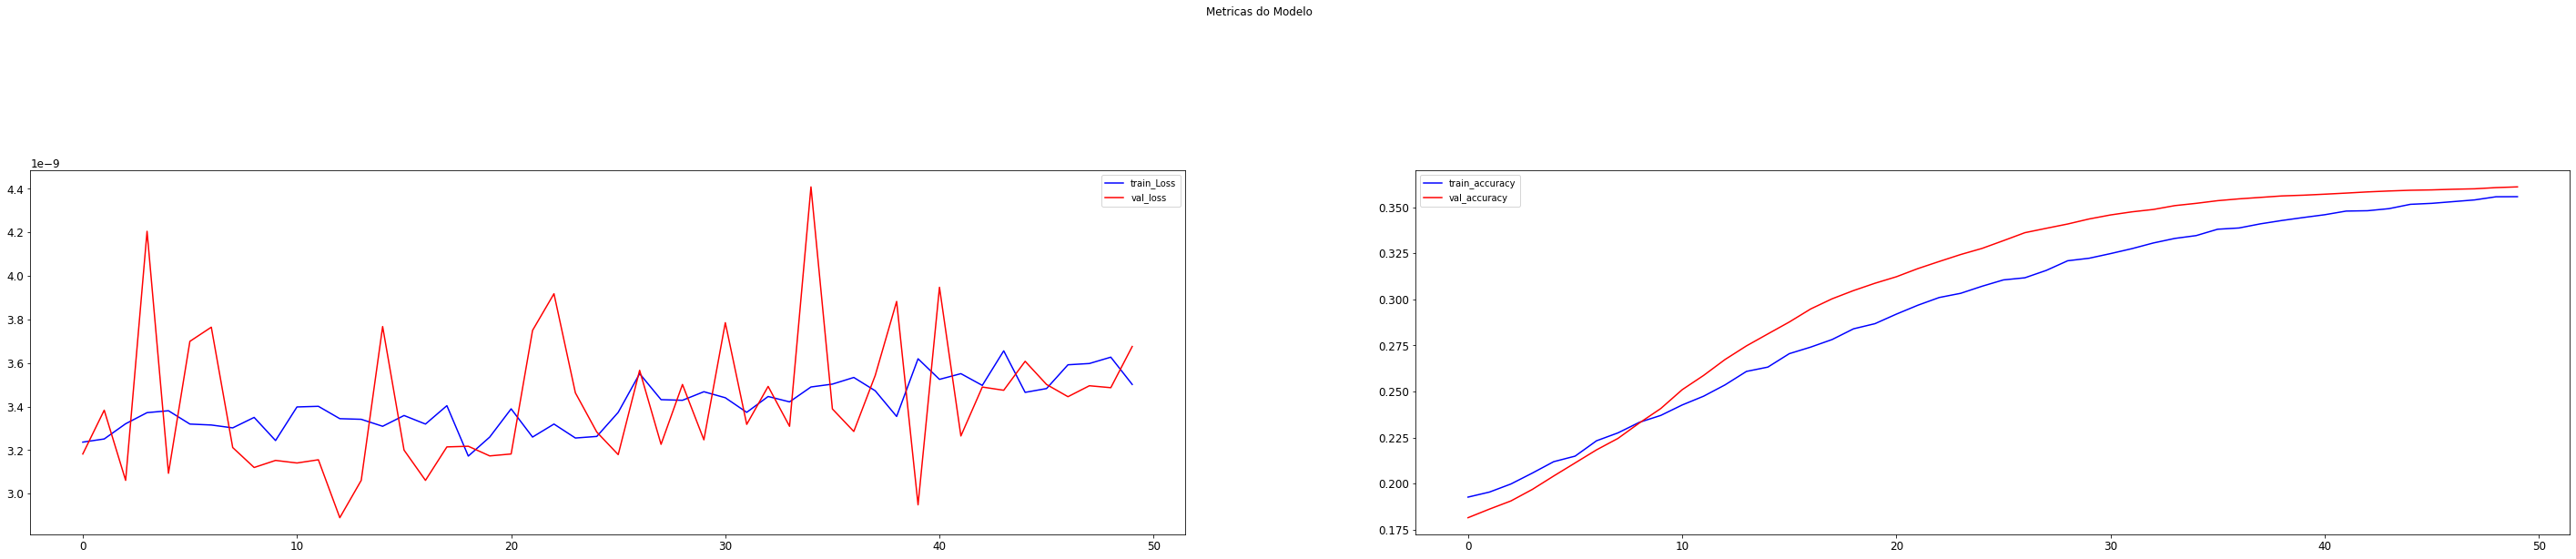

In [ ]:
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 50,25


plt.suptitle('Metricas do Modelo')

plt.subplot(3,2,1)
plt.plot(history.history['loss'],label='train_Loss',color = 'Blue')
plt.plot(history.history['val_loss'],label='val_loss',color = 'red')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(history.history['accuracy'],label='train_accuracy',color = 'Blue')
plt.plot(history.history['val_accuracy'],label='val_accuracy',color = 'red')
plt.legend(loc='best')

plt.show()

### Testes

In [ ]:
# variaveis globais para LSTM
OUTPUT_UNITS = len(data.code.unique()) # num of out put units (classes/labels/notas musicais)

NUM_UNITS = [256] # n of neurons of internal layers , each position correspond to a layer

LOSS = "sparse_categorical_crossentropy" # type of loss function 

LEARNING_RATE = 0.001 # learning rate to apply

EPOCHS = 40
BATCH_SIZE = 64

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf

In [ ]:
train_padded.shape

(42784, 810)

In [ ]:
# create design;architecture of model
input_layer = keras.layers.Input(shape=(None,train_padded.shape[1]))
lstm_layer = tf.compat.v1.keras.layers.CuDNNLSTM(NUM_UNITS[0])(input_layer)
dropout_layer = keras.layers.Dropout(0.2)(lstm_layer)
output_layer = keras.layers.Dense(OUTPUT_UNITS, activation='softmax')(dropout_layer)

model = keras.Model(input_layer,output_layer)

# compile
model.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics = ['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 810)]       0         
                                                                 
 cu_dnnlstm_5 (CuDNNLSTM)    (None, 256)               1093632   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,094,403
Trainable params: 1,094,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_label = np.array(train_label)
val_label = np.array(val_label)

In [ ]:
print(train_label.shape)
print(train_padded.shape)

(42784,)
(42784, 810)


In [ ]:
type(train_padded)

numpy.ndarray

In [ ]:
train_padded.ndim

2

In [ ]:
train_padded[0].shape

(810,)

In [ ]:
history = model.fit(train_padded, train_label, validation_data=(validation_padded,val_label), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/40


ValueError: ignored

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(3,activation='softmax'))

# import keras

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim))
# model.add(keras.layers.SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(3, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 810, 64)           320000    
                                                                 
 dropout (Dropout)           (None, 810, 64)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 386,435
Trainable params: 386,435
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### Training

In [ ]:
train_label = np.array(train_label)
val_label = np.array(val_label)

In [ ]:
# ok

In [ ]:
num_epochs = 2
history = model.fit(train_padded, train_label, epochs=num_epochs, validation_data=(validation_padded, val_label), verbose=1)

Epoch 1/2
1337/1337 [==============================] - 83s 56ms/step - loss: nan - accuracy: 2.3373e-04 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/2
1337/1337 [==============================] - 74s 55ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [ ]:
history.history['loss']

[nan, nan]

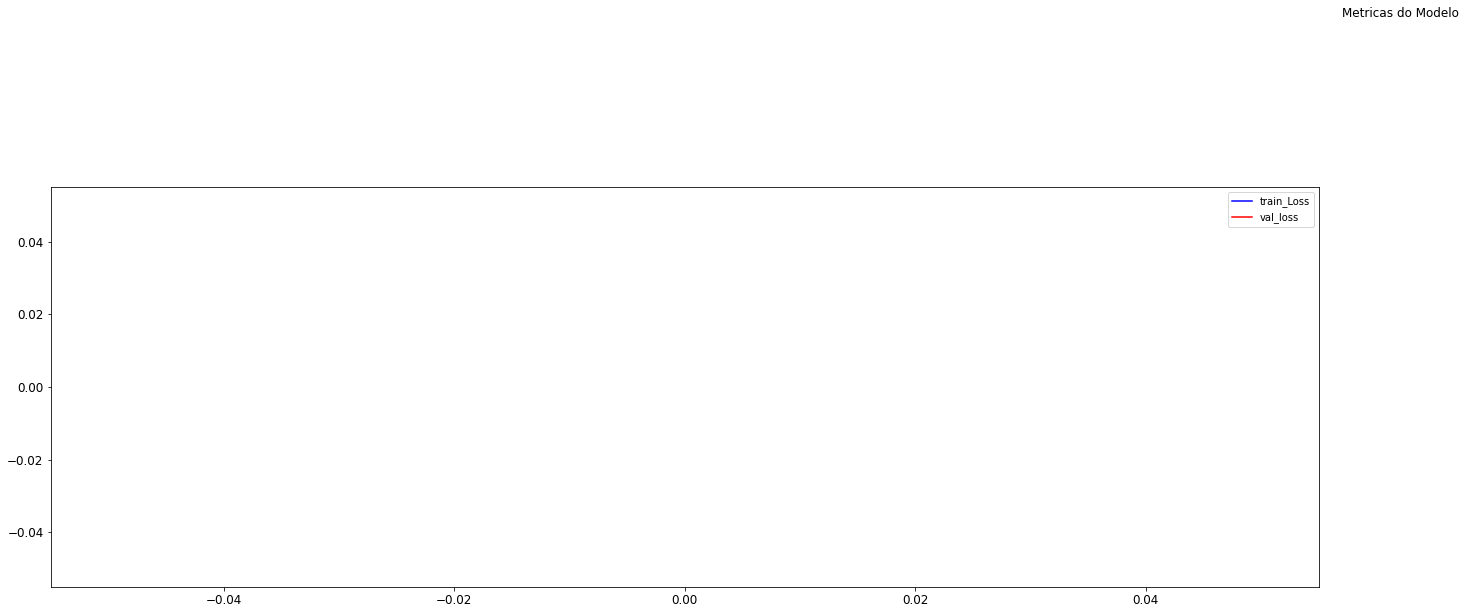

In [ ]:
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 50,25


plt.suptitle('Metricas do Modelo')

plt.subplot(3,2,1)
plt.plot(history.history['loss'],label='train_Loss',color = 'Blue')
plt.plot(history.history['val_loss'],label='val_loss',color = 'red')

plt.legend(loc='best')
plt.show()

### Glove

https://blog.paperspace.com/pre-trained-word-embeddings-natural-language-processing/

In [ ]:
!wget --no-check-certificate \
     https://nlp.stanford.edu/data/glove.twitter.27B.zip \
     -O /tmp/glove.twitter.27B.zip

--2022-09-16 19:43:36--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-09-16 19:43:37--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘/tmp/glove.twitter.27B.zip’

/tmp/glove.twitter. 100%[===================>]   1.42G  5.13MB/s    in 4m 45s  

2022-09-16 19:48:23 (5.10 MB/s) - ‘/tmp/glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [ ]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.twitter.27B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove') 

In [ ]:
!ls /tmp/glove

glove.twitter.27B.100d.txt  glove.twitter.27B.25d.txt
glove.twitter.27B.200d.txt  glove.twitter.27B.50d.txt


In [ ]:
import numpy as np
embeddings_index = {}
f = open('/tmp/glove/glove.twitter.27B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [ ]:
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

NameError: ignored

### BERT v1

In [ ]:
# # !pip install tensorflow
# # !pip install tensorflow_hub
# !pip install bert-for-tf2

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Model 
import bert

In [ ]:
max_seq_length = 128 
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [ ]:
# !pip install simpletransformers


In [ ]:
from simpletransformers.language_representation import RepresentationModel
        
sentences = ["Machine Learning and Deep Learning are part of AI", "Data Science will excel in future"] #it should always be a list

# sentences = data['text'].to_list()
model = RepresentationModel(
        model_type="bert",
        model_name="bert-base-uncased",
        use_cuda=True
    )

word_vectors = model.encode_sentences(sentences, combine_strategy=None)

In [ ]:
word_vectors.shape

In [ ]:
from simpletransformers.language_representation import RepresentationModel
sentences = ["Machine Learning and Deep Learning are part of AI", "Data Science will excel in future"] #it should always be a list
model = RepresentationModel(
        model_type="bert",
        model_name="bert-base-uncased",
        use_cuda=True
    )
sentence_vectors = model.encode_sentences(sentences, combine_strategy="mean")

In [ ]:
sentence_vectors.shape

In [ ]:
len(sentence_vectors[0])

In [ ]:
ok

In [ ]:
# !pip install tensorflow-text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text


preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)
text_preprocessed = bert_preprocess_model(data.clean_text.to_list())

In [ ]:
ok

In [ ]:
text_preprocessed = bert_preprocess_model(data.clean_text.to_list())
text_preprocessed.keys()

In [ ]:
bert_model = hub.KerasLayer(encoder_url)
bert_results = bert_model(text_preprocessed)
bert_results.keys()


### BERT


In [ ]:
data = data[data.target != 'Irrelevant']
data = data[['clean_text','code']]
data.shape

In [ ]:
data.columns.values

In [ ]:
data.code.unique() # 3 pos | 2 - neu | 1- neg

In [ ]:
# !pip install bert-for-tf2
# !pip install sentencepiece

In [ ]:
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
tokenizer.tokenize("don't be so judgmental")

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))


In [ ]:
def bert_tokenize(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

In [ ]:
data['tokens'] = data.clean_text.apply(lambda x: bert_tokenize(x))
data

In [ ]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

data['tokens'] = data['clean_text'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
data.sample(10)

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("target", fontsize=12)
data["target"].reset_index().groupby("target").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
data = data[data.target != 'Irrelevant']


In [ ]:
print(data.target.unique())
print(data.code.unique())


### Split dataset_train 
* train
* validation

In [ ]:
# from sklearn.model_selection import train_test_split

# # split dataset
# df_train, df_val = train_test_split(data[['code','clean_text']], test_size=0.3)
# ## get target
# target_train = df_train["code"]
# target_val = df_val["code"]

### GloVe

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

In [ ]:
import numpy as np

words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'glove.6B.50d.txt')

In [ ]:
def glove_embedding(tokens,word_dict=words):
  
  vectors = []
  for token in tokens:
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)
#exemplo
glove_embedding(data['tokens'].iloc[0]).shape

In [ ]:
df_train, df_val = train_test_split(data, test_size=0.3)

In [ ]:
def df_to_X_y(dff):
  y = dff['code'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for token in dff['tokens']:
    message_as_vector_seq = glove_embedding(token)
    
    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)
  
  return all_word_vector_sequences, y

In [ ]:
X_train, y_train = df_to_X_y(df_train)

In [ ]:
print(len(X_train), len(X_train[0]))
print(len(X_train), len(X_train[65]))

In [ ]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [ ]:
pd.Series(sequence_lengths).describe()

In [ ]:
max_lenght = pd.Series(sequence_lengths).max() + 1

In [ ]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=max_lenght):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    
    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])
  
  return np.array(X_copy).astype(float)

In [ ]:
X_train = pad_X(X_train)

In [ ]:
print(len(X_train), len(X_train[0]), X_train.shape)
print(len(X_train), len(X_train[65]), X_train.shape)

In [ ]:
y_train.shape

In [ ]:
X_val, y_val = df_to_X_y(df_val)
X_val = pad_X(X_val)

print(X_val.shape, y_val.shape)

### Model


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([])
model.add(layers.Input(shape=(max_lenght, 50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts/model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy


cp = ModelCheckpoint('/content/drive/MyDrive/''Trabalho de Graduação''/scripts/model/', save_best_only=True)
# loss='sparse_categorical_crossentropy'
model.compile(loss=BinaryCrossentropy,optimizer=Adam(learning_rate=0.0001),metrics=['accuracy', AUC(name='auc')])


In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Bidirectional,Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [ ]:
model_glove = Sequential()
model_glove.add(Embedding(len(words), output_dim=100, input_length=max_lenght, trainable=False))
#model_glove.add(Dropout(0.2))
#model_glove.add(Conv1D(64, 2, activation='relu')) 
model_glove.add(LSTM(64))
model_glove.add(Dense(3, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_glove.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 2,verbose =1)
